<a href="https://colab.research.google.com/github/kbyshiro/CMAPSS_tasks/blob/main/utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# インポート



In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import optim 
import torch.nn as nn
import torch.nn.functional as F
import random 

np.random.seed(1234)
random.seed(0)
PYTHONSEED = 0

# ASLの導入

In [3]:
class ASL(nn.Module):
  '''
  m : シフト量
  gm : 負値のダウンウェート
  gp : 正値のダウンウェート

  '''
  def __init__(self, m=0, gm=0 , gp=0):
    super(ASL, self).__init__()
    self.m = m
    self.gm = gm
    self.gp = gp
    self.softmax = nn.Softmax(dim=1)
  
  def forward(self, input, target):
    '''
    input(Tensor, Float) : (batch, class)
    target(Tensor, Long) : (batch, ) 
    '''
    input = self.softmax(input)
    target = target.unsqueeze(1)
    target = torch.cat([target, 1-target], axis=1)

    
    lossp = (-target[:, 0]*(input[:, 1]**self.gp)*torch.log(input[:, 0])).sum()

    input_m = torch.maximum(input[:, 0]-self.m, torch.zeros((input.size()[0]))).unsqueeze(1)

    input_m = torch.cat([input_m, 1-input_m], axis=1)
    lossm = (-target[:, 1]*(input_m[:, 0]**self.gm)*torch.log(input_m[:, 1])).sum()
    loss = (lossp+lossm)/input.size()[0]
    return loss

In [4]:
t_true = torch.zeros(200, dtype=torch.long)
t_true[-15:] =1

y1 = torch.full((200,1), 0.1)
y1[-25:] =0.9
y2 = torch.full((200, 1), 0.1)
y2[-5:] =0.9

y1 = torch.cat((y1, 1-y1), dim=1)
y2 = torch.cat((y2, 1-y2), dim=1)

In [5]:
asl = ASL(m=0.2, gm=3, gp=0)
x = torch.randn((3, 2))
t = torch.rand(3)
ce = nn.CrossEntropyLoss()
asl(y1, t_true), ce(y1, t_true)

(tensor(0.0319), tensor(1.1311))

# コスト最小化モデルの導入

In [44]:
class CostOptimizationWithTBM():
  def __init__(self, c0, k1, k2, k3, T0):
    self.c0 = c0
    self.k1 = k1
    self.k2 = k2
    self.k3 = k3
    self.T0 = T0
    self.softmax = nn.Softmax(dim=1)
    return

  def setprob(self, input, target, unit_size = 100):
    input = self.softmax(input)
    self.lda = unit_size/len(target)
    N_TN, N_FP = 0, 0
    for x, y in zip(input[:, 0], target):
      if x < 0.2 and y == 1:
        N_TN+= 1
      elif x > 0.85 and y == 0:
        N_FP += 1
    self.mu = (N_TN+N_FP)/len(target)
    self.delta = N_TN/(N_TN+N_FP)
    return 

  def OptimizeTBM(self):
    '''
    t_opt1 :コストによる最適なTBM実施区間
    t_opt2 : 安全によるTBM実施区間の上限
    '''
    self.t_opt1 = np.sqrt(2*self.c0/(self.lda*self.mu*self.delta*(self.k3-self.k1-(1-self.delta)*self.mu/self.lda*self.k2)))
    self.t_opt2 = (self.T0**2/(self.delta*self.mu)*(3-self.lda*self.T0))**(1/3)
    self.t_opt = min(self.t_opt1, self.t_opt2)
    return self.t_opt
  
  def OptimizeCost(self, t):
    '''
    2次までテーラー展開した時のコストの算出
    '''
    self.C0 = self.c0/t    
    self.C1 = self.k1*self.lda*(1-self.delta*self.mu*t/2)
    self.C2 = self.k2*(1-self.delta)*self.mu*(1-self.delta*self.mu*t/2)
    self.C3 = 1/2*self.k3*self.lda*self.mu*self.delta*t
    self.c_opt = self.C0 + self.C1 + self.C2 + self.C3
    return self.c_opt

  def GetCostAndTBM(self, input, target, unit_size):
    self.setprob(input, target, unit_size)
    t_opt = self.OptimizeTBM()
    self.OptimizeCost(t_opt)
    return self.t_opt, self.c_opt


In [58]:
C0 = 100
k1 = 10
k2 = 100
k3 = 10000
T0 = 50

# トイデータの自動生成

In [59]:
def create_toydata(lifetime, target, residual, n_size):
  lifetime_t = np.random.normal(loc=lifetime, scale=50, size=n_size)
  lifetime_t = list(map(int, lifetime_t))
  lifetime_s2 = []
  lifetime_s3 = []
  for x in lifetime_t:
    lifetime_s2.append(int(np.random.normal(loc=x-target-residual, scale= 10)))
    lifetime_s3.append(int(np.random.normal(loc=x-target+residual, scale=10)))
  t_true = []
  y_s2 = []
  y_s3 = []
  for x, y, z in zip(lifetime_t, lifetime_s2, lifetime_s3):
    tmp = np.zeros(x)
    tmp[-target:]  = 1
    t_true.append(tmp)

    tmp = np.full((x, 2), fill_value=[np.log(0.1), np.log(0.9)])
    tmp[y:] = np.log(.9), np.log(.1)
    y_s2.append(tmp)

    tmp = np.full((x, 2), fill_value=[np.log(0.1), np.log(0.9)])
    tmp[z:] = np.log(.9), np.log(.1)
    y_s3.append(tmp)
  t_true = torch.tensor([item for sub in t_true for item in sub], dtype=torch.long)
  y_s2 = torch.tensor([item for sub in y_s2 for item in sub])
  y_s3 = torch.tensor([item for sub in y_s3 for item in sub])
  return t_true, y_s2, y_s3

In [60]:
t_true, y_s2, y_s3 = create_toydata(200, 20, 15, 1000)
print(t_true.size(), y_s2.size())

torch.Size([196999]) torch.Size([196999, 2])


In [61]:
print(asl(y_s2, t_true), asl(y_s3, t_true))

tensor(0.0460, dtype=torch.float64) tensor(0.1527, dtype=torch.float64)


In [62]:
CostOpt = CostOptimizationWithTBM(C0, k1, k2, k3, T0)
CostOpt.GetCostAndTBM(y_s2, t_true, unit_size=1000)

230 15595


(63.26863066971526, 11.128169725728096)

In [63]:
print(CostOpt.lda, CostOpt.mu, CostOpt.delta, CostOpt.t_opt1, CostOpt.t_opt2)

0.0050761678993294385 0.08033035700688836 0.014533965244865719 63.26863066971526 180.49659346413085


In [55]:
y = []
for x in range(1, 400):
  y.append(CostOpt.OptimizeCost(x))

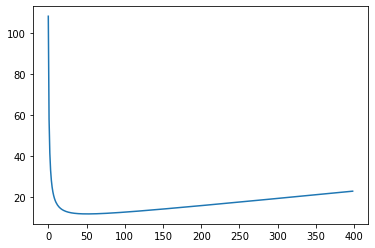

In [57]:
plt.plot(y)


# データセットへのラベル付け


In [ ]:
class DataSet:
    def __init__(self, X=[], t=[]):
        self.X = X # 入力
        self.t = t # 出力

    def __len__(self):
        return len(self.X) 

    def __getitem__(self, index):
        # index番目の入出力ペアを返す
        return self.X[index], self.t[index]
    

class FD_Dataset():
  def __init__(self, dataset_path="/content/drive/My Drive/CMAPSSData"):
    self._dataset_path = dataset_path
    
    # the files did not contain headers. Here we create labels based on documentation
    index_columns_names =  ["UnitNumber","Cycle"]
    op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
    sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
    self.column_names = index_columns_names + op_settings_columns + sensor_columns
    self.target_name = 'Target_RUL'
    self.label_name = 'Label'
    self.train = DataSet()
    self.test = DataSet()


  def load(self, data_id=1):
    '''
    やってること：
    train, test, rul.txt の読み込み
    Noneの値を落とす
    カラムの名前付け
    '''

    self._train_name = 'train_FD00{}.txt'.format(data_id)
    self._test_name = 'test_FD00{}.txt'.format(data_id)
    self._test_rul_name = 'RUL_FD00{}.txt'.format(data_id)
    self.raw_train = pd.read_csv(os.path.join(self._dataset_path, self._train_name), sep=" ", header=None)
    self.raw_test = pd.read_csv(os.path.join(self._dataset_path, self._test_name), sep=" ", header=None)
    self.raw_rul_test = pd.read_csv(os.path.join(self._dataset_path, self._test_rul_name), header=None)
    
    # drop pesky NULL columns
    self.raw_train.drop(self.raw_train.columns[[26, 27]], axis=1, inplace=True)
    self.raw_test.drop(self.raw_test.columns[[26, 27]], axis=1, inplace=True)

    # set name columns
    self.raw_train.columns = self.column_names
    self.raw_test.columns = self.column_names
    
  def CreateRUL(self):
      '''
      Train：CycleのデータからRULをせいせい
      Test:Cycleのデータとrul.txtの値からRULを生成
      rul.txtはTestUnitのサイクルが終了した時点でのRULの値を示している。
      '''
      # Train
      max_cycle = self.raw_train.groupby('UnitNumber')['Cycle'].max().reset_index()
      max_cycle.columns = ['UnitNumber', 'MaxOfCycle']
      
      # merge the max cycle back into the original frame
      raw_train_merged = self.raw_train.merge(max_cycle, on='UnitNumber', how='inner')
      
      # calculate RUL for each row
      Target_Remaining_Useful_Life = raw_train_merged["MaxOfCycle"] - raw_train_merged["Cycle"]
      
      # set DataSet instance
      self.train.X = raw_train_merged.drop("MaxOfCycle", axis=1)
      self.train.t = pd.Series(Target_Remaining_Useful_Life, name=self.target_name)

      #Test
      self.raw_rul_test['UnitNumber'] = self.raw_rul_test.index+1
      self.raw_rul_test.rename(columns={0:"ActualRUL"}, inplace=True)
      max_cycle = self.raw_test.groupby('UnitNumber')['Cycle'].max().reset_index()
      max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

      self.raw_rul_test["MaxRUL"] = self.raw_rul_test['ActualRUL']+max_cycle["MaxOfCycle"]
      self.raw_rul_test.drop("ActualRUL", axis=1, inplace=True)
      raw_test_merged = self.raw_test.merge(self.raw_rul_test,on='UnitNumber',how='left')
      Target_Remaining_Useful_Life = raw_test_merged['MaxRUL']-raw_test_merged['Cycle']
      
      # set DataSet instance
      self.test.X = raw_test_merged.drop("MaxRUL", axis=1)
      self.test.t = pd.Series(Target_Remaining_Useful_Life, name = self.target_name)
  
  def InsertFailure(self, x, target_alarm):
      last = x.index[-1]
      x.iloc[-target_alarm:] = 1
      return x
  
  def CreateLabel(self, target_alarm):
      '''
      Cycleの値からLabelの生成
      '''
      all_data = self.raw_train
      all_data['Label'] = 0
      all_data['Label'] = all_data.groupby('UnitNumber')['Label'].transform(self.InsertFailure, target_alarm=target_alarm)

      #split test data
      random.seed(1234)
      idx = random.sample(range(1, 101), 20)
      rest_idx = [i for i in range(1, 101) if i not in idx]
      test = all_data[all_data['UnitNumber'].isin(idx)]
      train = all_data[all_data['UnitNumber'].isin(rest_idx)]

      # Dataset instance 
      self.train.X = train.iloc[:, :-1]
      self.train.t = train.iloc[:, -1]

      self.test.X = test.iloc[:, :-1]
      self.test.t = test.iloc[:, -1]
      return self.train

  def DropConst(self):
      '''
      変化のないカラムとオプションを落とす
      '''
      leakage_to_drop = ['Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']
      leakage_to_drop += ['Sensor_'+str(i) for i in [1, 5, 6, 10, 16, 18, 19]]
      self.train.X.drop(leakage_to_drop, axis = 1, inplace=True)
      self.test.X.drop(leakage_to_drop, axis = 1, inplace=True)

  def MinMaxNorm(self):
      tmp = pd.concat([self.train.X.iloc[:, 1:], self.test.X.iloc[:, 1:]]).reset_index(drop=True)
      train_size = len(self.train)
      X_min, X_max = tmp.min(), tmp.max()
      tmp = (tmp-X_min)/(X_max-X_min)
      self.train.X.iloc[:, 1:] = tmp.iloc[:train_size, :]
      self.test.X.iloc[:, 1:] = tmp.iloc[train_size:, :].reset_index(drop=True)

  def LimitRUL(self, RUL_limit):
    self.train.t = pd.Series(np.minimum(self.train.t, RUL_limit), name=self.target_name)
    self.test.t = pd.Series(np.minimum(self.test.t, RUL_limit), name=self.target_name)

  def SlideWindow(self, dataset, ws, cs=1, model='DAG'):
    #X.size= (n-ws, cs, ws/cs, n_feautures)
    combined_dataset = pd.concat([dataset.X, dataset.t], axis=1)
    unit_max = combined_dataset['UnitNumber'].max()
    width = ws//cs
    X, y = [], []
    if model == 'DAG':
      for k in range(unit_max):
        tmp_data = combined_dataset[combined_dataset['UnitNumber']==k+1].drop('UnitNumber', axis=1).values
        n = len(tmp_data)
        for i in range(n-ws):
            X.append([tmp_data[i+(j)*width:i+(j+1)*width, :-1] for j in range(cs)])
            y.append(tmp_data[i+ws, -1])
    elif model == 'LSTM':
      for k in range(unit_max):
        tmp_data = combined_dataset[combined_dataset['UnitNumber']==k+1].drop('UnitNumber', axis=1).values
        n = len(tmp_data)
        for i in range(n-ws):
            X.append(tmp_data[i:i+width, :-1])
            y.append(tmp_data[i+ws, -1])
    else: 
      print('Invalid Mode name')
    dataset.X = torch.tensor(X).float()
    dataset.t = torch.tensor(y).float()
    return dataset

  def GetRULDataset(self, ws, cs, batch_size, data_id=1, limit_flag = False, limit_value = None, model='DAG'):
    self.load(data_id)
    self.CreateRUL()
    self.DropConst()
    self.MinMaxNorm()

    if limit_flag: 
      self.LimitRUL(limit_value)

    self.train = self.SlideWindow(self.train, ws, cs, model)
    self.test = self.SlideWindow(self.test, ws, cs, model)

    train_dataloader = torch.utils.data.DataLoader(self.train, batch_size= batch_size)
    test_dataloader = torch.utils.data.DataLoader(self.test, batch_size= 1)
    return train_dataloader, test_dataloader

  def GetLabelDataset(self, ws, cs, batch_size, data_id=1, target_alarm = 20, model='DAG'):
    self.load(data_id)
    self.CreateLabel(target_alarm)
    self.DropConst()
    self.MinMaxNorm()

    self.train = self.SlideWindow(self.train, ws, cs, model)
    self.test = self.SlideWindow(self.test, ws, cs, model)

    train_dataloader = torch.utils.data.DataLoader(self.train, batch_size= batch_size)
    test_dataloader = torch.utils.data.DataLoader(self.test, batch_size= 1)
    return train_dataloader, test_dataloader

In [ ]:
import pandas as pd

In [ ]:
ws = 30
cs = 10
batch_size = 100
fd = FD_Dataset()
train_dataloader, test_dataloader = fd.GetRULDataset(ws, cs, batch_size)

In [ ]:
grouped = fd.raw_train.groupby('UnitNumber')

In [ ]:
ws = 30
cs = 10
batch_size = 100
test_fd = FD_Dataset()
test_fd.load()
train_dataloader, test_dataloader = test_fd.GetLabelDataset(ws, cs, batch_size)

In [ ]:
train['Label']

0        0
1        0
2        0
3        0
4        0
        ..
20626    0
20627    0
20628    0
20629    0
20630    0
Name: Label, Length: 20631, dtype: int64

In [ ]:
a = {3, 4,5}
print(random.sample(a, 2))
idx = random.sample(range(1, 101), 20)

[3, 5]


In [ ]:
np.arange(30).reshape(3, 10)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])